In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from mapie.regression import MapieRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from mapie.metrics import regression_coverage_score

In [3]:
# loading the dataset from: 
# https://archive.ics.uci.edu/dataset/165/concrete+compressive+strength
df = pd.read_excel("Concrete_Data.xls")

In [104]:
df.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [5]:
# setting up a train_test split to do a very simple nested
# cross validation. the training set will be used to perform
# 10-fold cross-validation to train 10 models and 10 calibrated
# regressors. each one of them will be used to predict on
# the mean and alphas on the test set to see how well they 
# generalize

# where we select our desired alpha  
desired_alpha= 0.05

# the cv 
cv = KFold(n_splits=10, shuffle=True)

# separating features and target
X = df[df.columns[:-1]].copy()
y = df[df.columns[-1]]

# train-test split to examine performance of calibrator
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.12, random_state=22)

# resetting the indices so the split indices match up
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# creating a set of lists and arrays for the fold preds 
test_preds = []
test_pis = []

xgb_oof = np.zeros(len(X_train))

con_lower_oof = np.zeros(len(X_train))
con_upper_oof = np.zeros(len(X_train))

test_preds = []
test_bounds = []

for train, val in cv.split(X_train, y_train):

    train_x = X_train.iloc[train].copy()
    train_y = y_train[train]

    val_x = X_train.iloc[val].copy()
    val_y = y_train[val]
    
    # xgb model
    xgb = XGBRegressor()  
    xgb.fit(train_x, train_y)
    
    # calibrating the conformal regressor on the validation set
    con_mod = MapieRegressor(xgb, cv="prefit")
    con_mod.fit(val_x, val_y)
    
    # generating predictions on the calibration set
    con_lower_oof[val] = con_mod.predict(val_x, alpha=desired_alpha)[1][:,0].flatten()
    con_upper_oof[val] = con_mod.predict(val_x, alpha=desired_alpha)[1][:,1].flatten()
    
    # generating predictions on the entire *test* set using this fold's model
    test_preds_, test_pis_ = con_mod.predict(X_test, alpha=desired_alpha)

    xgb_oof[val] = xgb.predict(val_x)
    test_preds.append(test_preds_)
    test_pis.append(test_pis_)

In [7]:
oof_results = pd.DataFrame({
    'xgb' : xgb_oof,
    'xgb_lower' : con_lower_oof,
    'xgb_upper' : con_upper_oof,
    'width' : con_upper_oof - con_lower_oof,
    'actual' : y_train
    
})

print("coverage score on validation set:",
      regression_coverage_score(y_train, con_lower_oof, con_upper_oof))

oof_results.head()

coverage score on validation set: 0.9558498896247241


,xgb,xgb_lower,xgb_upper,width,actual
0,39.831448,32.200676,47.462219,15.261544,47.711739
1,33.386600,22.276644,44.496557,22.219912,33.399596
2,60.633194,46.300466,74.965922,28.665455,62.052840
3,29.376888,19.796730,38.957047,19.160317,24.497082
4,31.388895,20.278939,42.498851,22.219912,32.722531


Naturally, the coverage is well calibrated on the validation  
dataset.

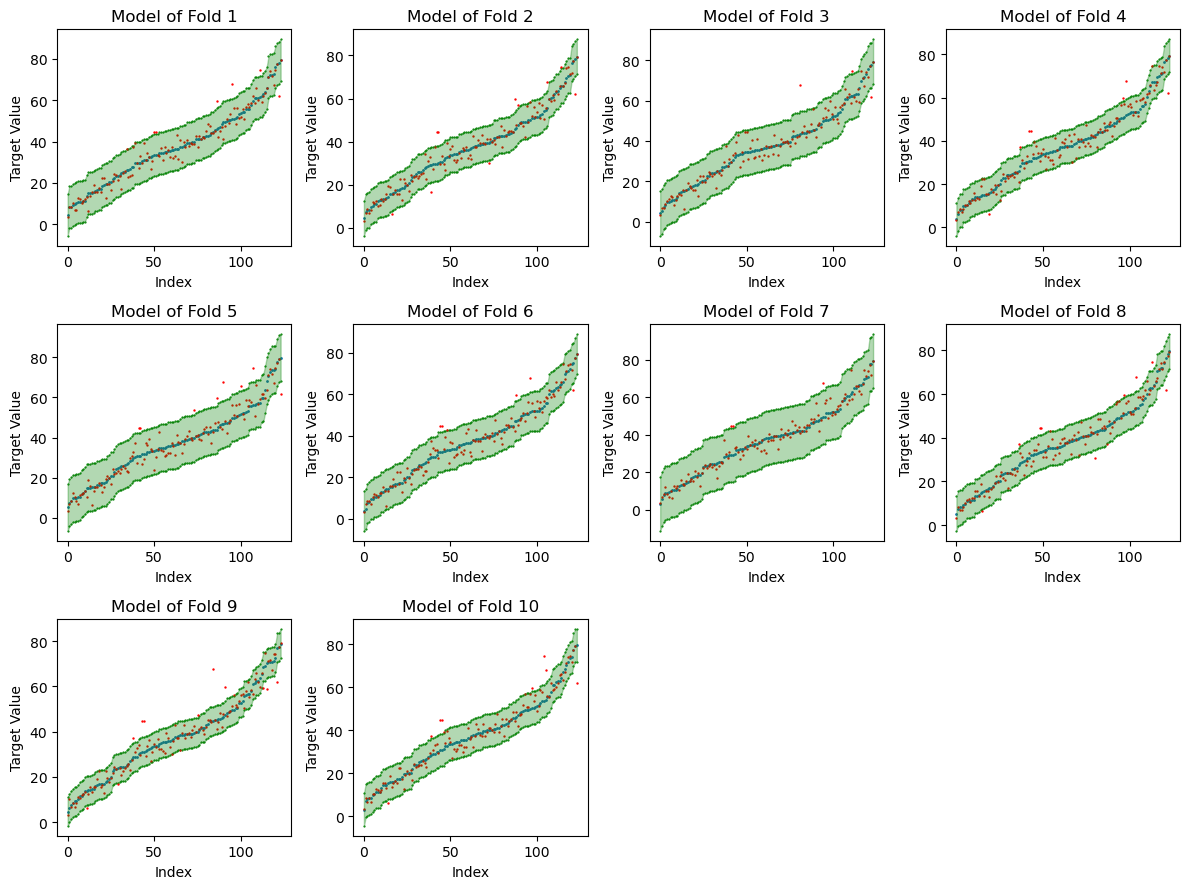

In [8]:
# creating plots for the 10 sets of predictions on the 
# test set. the green area is the prediction interval
# and the red dots are the actual values
# it's worth mentioning that the interval varies in this
# plot because the models differ - each model has its own
# specific interval. 

fig, axes = plt.subplots(3, 4, figsize=(12, 9))

for i, (preds, bounds) in enumerate(zip(test_preds, test_pis)):
    sorted_index = np.argsort(preds)
    sorted_lower = bounds[:, 0].flatten()[sorted_index]
    sorted_upper = bounds[:, 1].flatten()[sorted_index]
    sorted_real = y_test.reset_index(drop=True)[sorted_index]

    row = i // 4  
    col = i % 4  

    ax = axes[row, col]  

    ax.scatter(range(len(preds)), preds[sorted_index], s=1)
    ax.scatter(range(len(preds)), sorted_lower, s=0.3, color='green')
    ax.scatter(range(len(preds)), sorted_upper, s=0.3, color='green')
    ax.scatter(range(len(preds)), sorted_real, s=0.5, color='red')
    
    ax.fill_between(range(len(preds)), sorted_lower, sorted_upper, color='green', alpha=0.3)
    
    ax.set_xlabel('Target Value Inverse Rank')
    ax.set_ylabel('Target Value')
    ax.set_title(f'Model of Fold {i+1}')

if i < 11:
    for j in range(i+1, 12):
        row = j // 4
        col = j % 4
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

In [9]:
coverages = []

for bounds in test_pis:
    coverages.append(regression_coverage_score(y_test, bounds[:,0], bounds[:,1]))
    
print(f"the mean coverage on the test set with alpha {desired_alpha} is:", np.mean(coverages))

the mean coverage on the test set with alpha 0.05 is: 0.9362903225806452


In [ ]:
# now i want to try a test using the MapieQuantileRegressor
# and compare it to the coverage of LGBMRegressor with
# objective = 'quantile'

lgbm_oof = np.zeros(len(X))
lgbm_low = np.zeros(len(X))
lgbm_high = np.zeros(len(X))

mapie_qr_low = np.zeros(len(X))
mapie_qr_high = np.zeros(len(X))

lgbm_test = []
lgbm_low_test = []
lgbm_high_test = []

mapie_test = []
mapie_pi_test = []

q_kfold = KFold(n_splits=10, shuffle=True, random_state=12)

for train, val in q_kfold.split(X_train, y_train):
    
    train_x = X_train.iloc[train].copy()
    train_y = y_train[train]

    val_x = X_train.iloc[val].copy()
    val_y = y_train[val]
    
    lgbm_mean_model = LGBMRegressor(objective='quantile', alpha=0.5)
    lgbm_low_model = LGBMRegressor(objective='quantile', alpha=0.05)
    lgbm_high_model = LGBMRegressor(objective='quantile', alpha=0.95)
    
    lgbm_mean_model.fit(train_x, train_y, eval_set=[(val_x, val_y)], early_stopping_rounds=15)
    lgbm_low_model.fit(train_x, train_y, eval_set=[(val_x, val_y)], early_stopping_rounds=15)
    lgbm_high_model.fit(train_x, train_y, eval_set=[(val_x, val_y)], early_stopping_rounds=15)
    
    mapie_base = LGBMRegressor(objective='quantile', alpha=0.5)
    mapie_quantile_regressor = MapieQuantileRegressor(mapie_base, method="quantile", cv="split", alpha=0.1)    
    mapie_quantile_regressor.fit(train_x, train_y, X_calib=val_x, y_calib=val_y)
    
    lgbm_mean_pred = lgbm_mean_model.predict(X_test)
    lgbm_low_pred = lgbm_low_model.predict(X_test)
    lgbm_high_pred = lgbm_high_model.predict(X_test)
    
    mapie_preds, mapie_pis = mapie_quantile_regressor.predict(X_test)
    
    lgbm_test.append(lgbm_mean_pred)
    lgbm_low_test.append(lgbm_low_pred)
    lgbm_high_test.append(lgbm_high_pred)
    
    mapie_test.append(mapie_preds)
    mapie_pi_test.append(mapie_pis)

In [73]:
# comparing performance on the test set - to simplify, i chose
# one (the first) set of predictions on the test set. went a 
# bit overboard on the crossvalidation for this exercise
quantile_comparison_df = pd.DataFrame(np.reshape(mapie_pi_test[0], (124, 2)))
quantile_comparison_df.rename(columns={0 : 'mapie_low', 1 : 'mapie_high'}, inplace=True)
quantile_comparison_df['lgbm_q50'] = lgbm_test[0]
quantile_comparison_df['lgbm_low'] = lgbm_low_test[0]
quantile_comparison_df['lgbm_high'] = lgbm_high_test[0]

quantile_comparison_df['actual'] = y_test.values

In [80]:
# calculating interval widths
quantile_comparison_df['lgbm_width'] = quantile_comparison_df['lgbm_high'].sub(quantile_comparison_df['lgbm_low'])
quantile_comparison_df['mapie_width'] = quantile_comparison_df['mapie_high'].sub(quantile_comparison_df['mapie_low'])
quantile_comparison_df['width_diff'] = quantile_comparison_df['mapie_width'].sub(quantile_comparison_df['lgbm_width'])

In [125]:
quantile_comparison_df[['lgbm_width', 'mapie_width']].mean()

lgbm_width     16.216623
mapie_width    19.008295
dtype: float64

In [102]:
print("the coverage of the original LGBM model is poor:",
      regression_coverage_score(quantile_comparison_df['actual'],
                                quantile_comparison_df['lgbm_low'],
                                quantile_comparison_df['lgbm_high'])
     )

the coverage of the original LGBM model is poor: 0.717741935483871


In [103]:
print("the coverage of the conformalized model is bang on:",
      regression_coverage_score(quantile_comparison_df['actual'],
                                quantile_comparison_df['mapie_low'],
                                quantile_comparison_df['mapie_high'])
     )

the coverage of the conformalized model is bang on: 0.9032258064516129


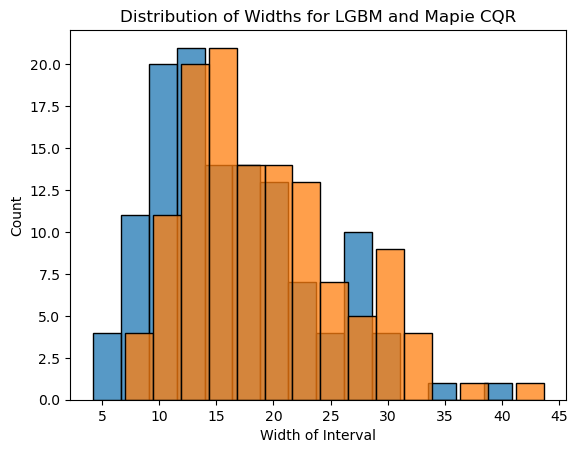

In [101]:
import seaborn as sns

sns.histplot(quantile_comparison_df['lgbm_width'], bins=15)
sns.histplot(quantile_comparison_df['mapie_width'], bins=15)

plt.xlabel("Width of Interval")
plt.title("Distribution of Widths for LGBM and Mapie CQR")
plt.show()

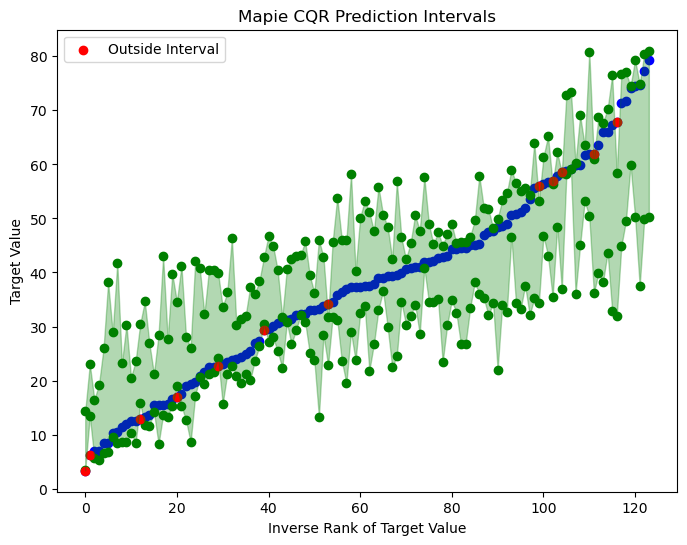

In [106]:
fig, ax = plt.subplots(figsize=(8, 6))

actual_ranked = np.argsort(quantile_comparison_df['actual'])

mid_pred = quantile_comparison_df.iloc[actual_ranked]['actual']
mapie_low = quantile_comparison_df.iloc[actual_ranked]['mapie_low']
mapie_high = quantile_comparison_df.iloc[actual_ranked]['mapie_high']

ax.scatter(x=range(len(actual_ranked)), y=mid_pred, color='blue')
ax.scatter(x=range(len(actual_ranked)), y=mapie_low, color='green')
ax.scatter(x=range(len(actual_ranked)), y=mapie_high, color='green')

# finding the indices where the actual value is outside the interval
# and displaying them as red rather than blue

outlier_indices = np.logical_or(mid_pred > mapie_high, mid_pred < mapie_low)
ax.scatter(x=np.where(outlier_indices)[0], y=mid_pred[outlier_indices], color='red',
           label='Outside Interval')


ax.fill_between(range(len(actual_ranked)), mapie_low, mapie_high, color='green', alpha=0.3)

plt.title("Mapie CQR Prediction Intervals")
ax.set_xlabel("Inverse Rank of Target Value")
ax.set_ylabel("Target Value")

plt.legend()
plt.show()

In [111]:
# out of curiosity, can we use prefit models in our
# mapie quantile regressor? that would be nice
# i'm going to use the last X_train, y_train,
# and x_val, y_val only to illustrate

alpha = 0.1

median_model = LGBMRegressor(objective='quantile', alpha=0.5, n_estimators=100, max_depth=4)
low_model = LGBMRegressor(objective='quantile', alpha=0.05, n_estimators=75, max_depth=2)
high_model = LGBMRegressor(objective='quantile', alpha=0.95, n_estimators=125, max_depth=3)

median_model.fit(train_x, train_y)
low_model.fit(train_x, train_y)
high_model.fit(train_x, train_y)

# here we supply a list of models in the form of alpha/2, (1 - (alpha/2), median
# and specify cv='prefit' in order to use estimators with different parameters
# this will allow optimization on each 
mp_qr = MapieQuantileRegressor([low_model, high_model, median_model], cv='prefit')
mp_qr.fit(val_x, val_y)

mp_qr_pred, mp_qr_pi = mp_qr.predict(X_test)

In [126]:
low_model_preds = low_model.predict(X_test)
high_model_preds = high_model.predict(X_test)

mp_qr_interval = np.reshape(mp_qr_pi, (124, 2))

mp_qr_test_df = pd.DataFrame({'median_pred' : mp_qr_pred,
                              'unconformed_low_pred' : low_model_preds,
                              'unconformed_high_pred' : high_model_preds,
                              'conformed_low_pred' : mp_qr_interval[:,0],
                              'conformed_high_pred' : mp_qr_interval[:,1],
                              'actual' : y_test})

In [127]:
print("the coverage of the original model:",
      regression_coverage_score(mp_qr_test_df['actual'],
                                mp_qr_test_df['unconformed_low_pred'],
                                mp_qr_test_df['unconformed_high_pred'])
     )

the coverage of the original model: 0.8145161290322581


In [128]:
print("the coverage of the conformed models:",
      regression_coverage_score(mp_qr_test_df['actual'],
                                mp_qr_test_df['conformed_low_pred'],
                                mp_qr_test_df['conformed_high_pred'])
     )

the coverage of the conformed models: 0.8951612903225806
